# Try changing the labels to [0 0.25 0.5 1]
## I don't think is actually necessary to make a prob of this one. The results are not that promising and don't work for everyone.

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization, Flatten, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing
from functools import reduce
from scipy.fftpack import dct, idct
from scipy import signal

from Code.data_loaders import load_data_labels_based_on_dataset
from share import datasets_basic_infos
from Code.data_utils import train_test_val_split

In [50]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.


subject_id = 1  # Only two things I should be able to change
dataset_name = 'nieto'  # Only two things I should be able to change

# Folders and paths
dataset_foldername = dataset_name + '_dataset'
data_path = "/Users/almacuevas/work_projects/voting_system_platform/Datasets/" + dataset_foldername
dataset_info = datasets_basic_infos[dataset_name]

data, label = load_data_labels_based_on_dataset(dataset_name, subject_id, data_path, array_format=True)


In [51]:
# substract data from list
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(dataX = data, dataY= label, valid_flag=True)

# get data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape
N_test, T_test, C_test = X_test.shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
if (N_val > 0): y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [52]:
# Filtering through FFT(discrete cosine transform)

def filter(x, low=0, high=1, plot=False):
    N = x.shape[0]
    t = np.linspace(0,N,N)
    y = dct(x, norm='ortho')
    window = np.zeros(N)
    window[int(low*N):int(high*N)] = 1
    yr = idct(y*window, norm='ortho')
    sum(abs(x-yr)**2) / sum(abs(x)**2)
    if plot:
        plt.plot(t, x, '-b')
        plt.plot(t, yr, 'r')
    return x

# Filter band
low_freq = 0.02
high_freq = 0.4

for i in np.arange(N_train):
    for j in np.arange(C_train):
       X_train[i,:,j]= filter(X_train[i,:,j],low_freq,high_freq)
for i in np.arange(N_val):
    for j in np.arange(C_val):
       X_val[i,:,j]= filter(X_val[i,:,j],low_freq,high_freq)
    
for i in np.arange(N_test):
    for j in np.arange(C_test):
       X_test[i,:,j]= filter(X_test[i,:,j],low_freq,high_freq)


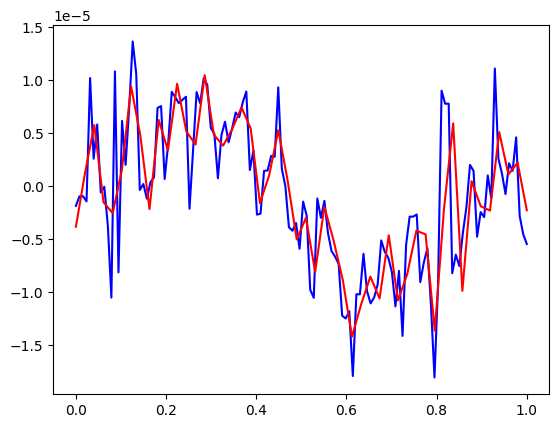

In [53]:
# Downsampling in time through FFT

t_sample = 50
X_train_sub = signal.resample(X_train,t_sample,axis=1)
if (N_val > 0): X_val_sub = signal.resample(X_val,t_sample,axis=1)
X_test_sub = signal.resample(X_test,t_sample,axis=1)

# show a downsampling example
plt.plot(np.linspace(0,1,T_train),X_train[5,:,5],'-b')
plt.plot(np.linspace(0,1,t_sample),X_train_sub[5,:,5],'-r')

In [54]:
print(X_train_sub.shape)

(150, 50, 512)


In [55]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [56]:
# def downsample(data, mul=10, enableTrunc = False):
#     assert data.shape[0] % mul == 0 or  enableTrunc, "Can't downsample without data truncation.\
#                                                 \n Set another value of mul or set enableTrunc = True"
#     outdata = []
#     for i in range(data.shape[0]//mul):
#         outdata.append(np.mean(data[i*mul:(i+1)*mul,...], axis=0, keepdims=True))
#     outdata = reduce(lambda a,b: np.append(a,b,0), outdata)
    
#     return outdata
# span = 2
# X_train_sub = np.expand_dims(downsample(X_train[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_train.shape[0]):
#     X_train_sub = np.append(X_train_sub,
#                             np.expand_dims(downsample(X_train[n,:,:], mul=span),axis=0),axis=0)

# X_val_sub = np.expand_dims(downsample(X_val[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_val.shape[0]):
#     X_val_sub = np.append(X_val_sub,
#                             np.expand_dims(downsample(X_val[n,:,:], mul=span),axis=0),axis=0)

# print('X_train_sub: ', X_train_sub.shape)
# print('X_val_sub: ', X_val_sub.shape)

In [57]:
# Expected input shape: ([batch_size], timesteps, data_dim)
# Note that we have to provide the full batch_input_shape if the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
seq_split = 1 # Set to one when using FFT to down sample
seq_len = int(X_train_sub.shape[1]*seq_split)
timesteps = seq_len
num_classes = 4
batch_size = 200
num_epoch = 100

model = Sequential()
#1
model.add(LSTM(200, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.6, input_shape=(timesteps, data_dim)))

#2
model.add(LSTM(100, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5))

#3
model.add(LSTM(50, return_sequences=True, stateful=False,
          recurrent_dropout=0.4, dropout = 0.4))
model.add(Flatten())

#4
model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#5
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, mode='auto')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=f'/Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model_{dataset_name}.hdf5', monitor='val_acc', verbose=1)#, initial_value_threshold=0.4)

callbacks_list = [earlystop, checkpointer]

In [58]:
history = model.fit(X_train_sub[:,:seq_len,:], y_train,
                    batch_size=batch_size, epochs=num_epoch, shuffle=True,
                    validation_split = 0.15, callbacks=callbacks_list)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.3863 - accuracy: 0.2520
Epoch 1: saving model to /Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model_nieto.hdf5
1/1 [==============================] - 3s 3s/step - loss: 1.3863 - accuracy: 0.2520 - val_loss: 1.3859 - val_accuracy: 0.3913
Epoch 2/100


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - ETA: 0s - loss: 1.3911 - accuracy: 0.2362
Epoch 2: saving model to /Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model_nieto.hdf5
1/1 [==============================] - 0s 264ms/step - loss: 1.3911 - accuracy: 0.2362 - val_loss: 1.3892 - val_accuracy: 0.1739
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.2756
Epoch 3: saving model to /Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model_nieto.hdf5
1/1 [==============================] - 1s 545ms/step - loss: 1.3832 - accuracy: 0.2756 - val_loss: 1.3849 - val_accuracy: 0.1739
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.4145 - accuracy: 0.2598
Epoch 4: saving model to /Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model_nieto.hdf5
1/1 [==============================] - 1s 614ms/step - loss: 1.4145 - accuracy: 0.2598 - val_loss: 1.3807 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


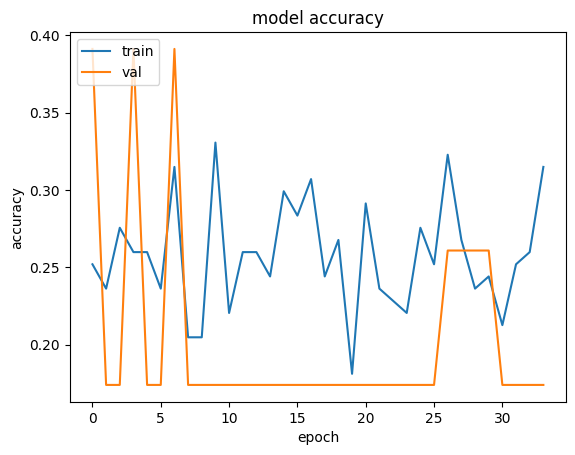

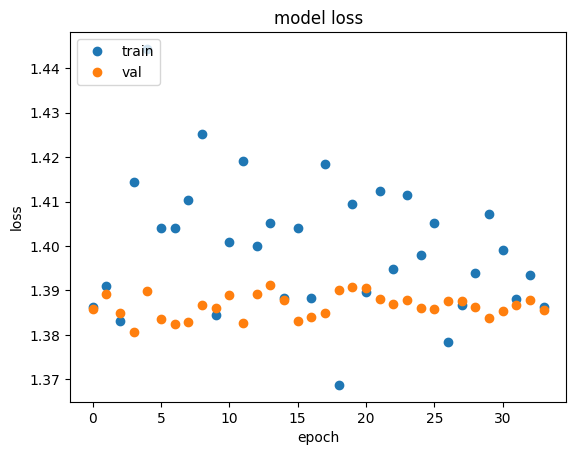

In [59]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
# evaluate model on entire training set
#model = load_model('/Users/almacuevas/work_projects/voting_system_platform/Code/BigProject/LSTM_model.hdf5')
results = model.evaluate(X_train_sub,y_train,batch_size=N_train)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 174ms/step - loss: 1.3844 - accuracy: 0.2467
test loss, test acc: [1.384416937828064, 0.24666666984558105]


In [61]:
# evaluate model on test set
results = model.evaluate(X_test_sub,y_test,batch_size=N_test)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 58ms/step - loss: 1.3883 - accuracy: 0.3000
test loss, test acc: [1.3882992267608643, 0.30000001192092896]


In [ ]:
# TODO: The model is not being saved